# Introduction

This notebook presents **lca-algebraic** a small libray above **brightay2**, designed for the definition of **parametric inventories** with fast computation of LCA impacts, suitable for **monte-carlo** analyis.

**lca-algebraic** provides a set of  **helper functions** for : 
* **compact** & **human readable** definition of activites :  
    * search background (tech and biosphere) activities 
    * create new foreground activites with parametrized amounts
    * parametrize / update existing background activities (extending the class **Activity**)
* Definition of parameters
* Computation of LCAs 
* Computation of statistics (including Sobols indices)
* Compute simplified parametric model by fixing minor input parameters

  
## Principles 

The main idea of this libray is to move from **procedural definition** of models (slow and prone to errors) to a **declarative / purely functionnal** definition of parametric models (models as **pure functions**). 

This enables **fast computation of LCA impacts**, useful for Monte Carlo methods and statistical analysis. 
We leverage the **power of symbolic calculus** provided by the library [SymPy](https://www.sympy.org/en/index.html).

We define our model in a **separate database**, as a nested combination of : 
* other foreground activities
* background activities :
    * Technical, refering **ecoinvent DB**
    * Biosphere, refering **brightway2** biosphere activities
    
The **amounts** in exchanges are expressed either as **static amounts**, or **symbolic expressions** of pre-defined **parameters**.

Each activity of our **root model** is defined as a **parametrized combination** of the **foreground activities**, which can themselves be expressed by the **background activities**.

When computing LCA for foreground models, the library develops the model as a combination of **only background activities**. It computes **once for all** the impact of **all required background activities** and compiles a **fast numpy** (vectorial) function for each impact, replacing each background activity by the **static value of the corresponding impact**.

By providing **large vectors** of **parameter values** to those numpy functions, we can compute LCA for **thousands of values** at a time.

![](https://oie-mines-paristech.github.io/lca_algebraic/doc/lca-algebraic.png)


## Compatiblity with brightway2 

Under the hood, the activities we define with **lca-algebraic** are standard **brightway2** activities. 
The amounts of exchanges are stored as **float values** or **serialized as string** in the property **formula**.

Parameters are also stored in the **brightay2** projets, making it fully compatible with **brightway**.

Thus, a model defined with **lca-algebraic** is stored as a regular **bw2** projet. We can use **bw2** native support for [parametrized dataset](https://2.docs.brightway.dev/intro.html#parameterized-datasets) for computing LCAs, even if much more slower than the method explain here.

## Doc

The followng notebook explores the main functions.
Full documentation of the functions is [available here](https://oie-mines-paristech.github.io/lca_algebraic/doc/)

In [1]:
# Those two lines are for dev only : they watch imported libraries for changes
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import brightway2 as bw

# Custom utils defined for inter-acv
from lca_algebraic import *
from lca_algebraic.stats import * 
import lca_algebraic
from sympy import init_printing, simplify

init_printing()

/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/databases.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/methods.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/normalizations.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/weightings.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/databases.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/methods.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/normalizations.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/weightings.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/migrations.json
/home/rjolivet/.local/share/Brightway3/default.c21f969b5f03d33d43e04f8f136e7682/unlinked_data.json


/home/rjolivet/anaconda3/envs/acv3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Init brightway2 and databases

In [3]:
### Init the brightway2 project :choose any project name
initProject('MyProject')

# Import Ecoinvent DB (if not already done)
# Update the name and path to the location of the ecoinvent database
importDb("ecoinvent 3.4", './ecoinvent 3.4_cutoff_ecoSpold02/datasets')

# We use a separate DB for defining our foreground model / activities
# Choose any name
USER_DB = 'Foreground DB'

Extracting ecospold2 files:


/home/rjolivet/.local/share/Brightway3/MyProject.6801fb521646e13e5eabca9a6bd84430/databases.json
/home/rjolivet/.local/share/Brightway3/MyProject.6801fb521646e13e5eabca9a6bd84430/methods.json
/home/rjolivet/.local/share/Brightway3/MyProject.6801fb521646e13e5eabca9a6bd84430/normalizations.json
/home/rjolivet/.local/share/Brightway3/MyProject.6801fb521646e13e5eabca9a6bd84430/weightings.json
/home/rjolivet/.local/share/Brightway3/MyProject.6801fb521646e13e5eabca9a6bd84430/migrations.json
/home/rjolivet/.local/share/Brightway3/MyProject.6801fb521646e13e5eabca9a6bd84430/unlinked_data.json
Biosphere database already present!!! No setup is needed


0% [##############################] 100% | ETA: 00:00:00 | Item ID: 82af64d7-c56e-4
Total time elapsed: 00:01:56


Title: Extracting ecospold2 files:
  Started: 02/28/2022 11:53:58
  Finished: 02/28/2022 11:55:54
  Total time elapsed: 00:01:56
  CPU %: 97.50
  Memory %: 7.58
Extracted 14889 datasets in 116.35 seconds
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
/home/rjolivet/.local/share/Brightway3/MyProject.6801fb521646e13e5eabca9a6bd84430/migrations/fix-ecoinvent-flows-pre-35.8a1947cccbeab5ee4e017f41b83b2110.json
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_intern

Writing activities to SQLite3 database:
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:07


Title: Writing activities to SQLite3 database:
  Started: 02/28/2022 11:56:07
  Finished: 02/28/2022 11:57:14
  Total time elapsed: 00:01:07
  CPU %: 69.30
  Memory %: 8.56
Created database: ecoinvent 3.4


In [4]:
# This is better to cleanup the whole foreground model each time, and redefine it in the notebook
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
resetDb(USER_DB)

# Parameters are stored at project level : 
# Reset them also
# You may remove this line if you import a project and parameters from an external source (see loadParam(..))
resetParams()

# Overview of the databases
list_databases()

Db Foreground DB was here. Reseting it


,backend,type
name,,
biosphere3,sqlite,background
ecoinvent 3.4,sqlite,background
Foreground DB,sqlite,foreground


# Introduction to Numpy


Numpy is a python libray for symbolic calculus. 

You write Sympy expression as you write **standard python expressions**, using **sympy symbols** in them. 


The result is then a **symbolic expression that can be manipulated**, instead of a **numeric value**.

In [5]:
from sympy import symbols 

# create sympy symbol
a = symbols("a")

# Expressions are not directly evaluated 
f = a * 2 + 4 
f

In [6]:
# symbols can be replaced by values afterwards 
f.subs(dict(a=3))

In practice, you don't need to care about Sympy. Just remember that : 
* The parameters defined below are **instances of sympy symbols**
* Any **valid python expression** containing a **sympy symbol** will create a **sympy symbolic expression**

# Define input parameters

First, we define the input parameters of the model together with their distribution.

The numeric parameters are **instances of sympy 'Symbol'**. 

Thus, any python arithmetic expression composed of parameters will result in a **symbolic expression** to be used later in the definition of the model, rather than a static numeric result.

In [7]:
# Example of 'float' parameters
a = newFloatParam(
    'a', 
    default=0.5, min=0.2, max=2,  distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world",
    label="extended label for a")

b = newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    description="foo bar")

# Parameters can be attached to a specific DB instead of global project
# We recommand this for team working / working with several DBs
# lca_algebraic supports resolution of parameters with duplicate names attached to different scopes 
b2 = newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    description="foo bar",
    dbname=USER_DB)

share_recycled_aluminium = newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, min=0, max=1, std=0.2, distrib=DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

c = newFloatParam(
    'c',  
    default=0.6, std=0.2, distrib=DistributionType.LOGNORMAL)

beta = newFloatParam(
    'beta',  
    default=0.6, std=0.2, a=2, b=5, distrib=DistributionType.BETA)

# You can define boolean parameters, taking only discrete values 0 or 1
bool_param = newBoolParam(
    'bool_param', 
    default=1)

# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], # If provided as list, all possibilities have te same probability
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = newEnumParam(
    'techno_param', 
    values={
        "technoA":0.4, 
        "technoB":0.1,
        "technoC":0.5}, # You can provide a statistical weight for each value, by using a dict
    default="technoA", 
    description="Choice of techonoly")

No 'min/max' provided, param b marked as FIXED
No 'min/max' provided, param b marked as FIXED


In [8]:
# List of parameters
list_parameters()

group,name,label,default,min,max,std,distrib,unit,db
,a,extended label for a,0.5,0.2,2,,triangle,,[project]
,b,b,0.5,,,,fixed,,[project]
,b,b,0.5,,,,fixed,,Foreground DB
,beta,beta,0.6,,,0.2,beta,,[project]
,bool_param,bool param,1,,,,,,[project]
,c,c,0.6,,,0.2,lognormal,,[project]
,elec_switch_param,elec switch param,us,,,,,,[project]
,share_recycled_aluminium,share recycled aluminium,0.6,0,1,0.2,normal,,[project]
,techno_param,techno param,technoA,,,,,,[project]


## Persistance of parameters

By default, new parameters are kept in memory but also persisted in the project (unless save=False).
You can persist parameters afterwards with `persistParams()`.
You can load also load parameters from an existing database with `loadParams()`.
The persistance of parameters and the distribution is compatible with **Brightway2** and **Activity Browser**  [see documentation of stat_arrays](https://stats-arrays.readthedocs.io/en/latest/)

In [9]:
# Load parameters previously  persisted in the dabatase.
loadParams()

[ParamRegistry] Param b was already defined in 'Foreground DB' : overriding.
[ParamRegistry] Param b was already defined in 'Foreground DB' : overriding.
[ParamRegistry] Param a was already defined in '<project>' : overriding.
[ParamRegistry] Param a was already defined in '<project>' : overriding.
[ParamRegistry] Param b was already defined in '<project>' : overriding.
[ParamRegistry] Param b was already defined in '<project>' : overriding.
Variable 'b' was already defined : overidding it with param.
[ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[ParamRegistry] Param c was already defined in '<project>' : overriding.
[ParamRegistry] Param c was already defined in '<project>' : overriding.
[ParamRegistry] Param beta was already defined in '<project>' : overriding.
[ParamRegistry] Param beta was already defined in '<project>' : overriding.
[Pa

# Manage several Datasets

lca_algebraic supports several foreground / background datasets. Background datasets are considered static / non parametrized by the library : they use standard LCA method of **Brightway2**. 

Foreground databases are considered parametric and their activities are developped as functions of parameters and background activities.

## Set status of a database

The functions **setForeground(...)** and **setBackground(...)** change the status of a database.

In [10]:
setBackground(USER_DB)
list_databases()

,backend,type
name,,
biosphere3,sqlite,background
ecoinvent 3.4,sqlite,background
Foreground DB,sqlite,background


In [11]:
setForeground(USER_DB)
list_databases()

,backend,type
name,,
biosphere3,sqlite,background
ecoinvent 3.4,sqlite,background
Foreground DB,sqlite,foreground


## Import / export

`lca_algebraic` extends [BW2Package](https://2.docs.brightway.dev/technical/bw2io.html), adding persistence of parameters.

In [12]:
# Save database and parameters as Bzipped JSON
export_db(USER_DB, "db.bw2") 

In [13]:
# Reimport DB
import_db("db.bw2")

[ParamRegistry] Param b was already defined in 'Foreground DB' : overriding.
[ParamRegistry] Param b was already defined in 'Foreground DB' : overriding.
Variable 'b' was already defined : overidding it with param.
[ParamRegistry] Param a was already defined in '<project>' : overriding.
[ParamRegistry] Param a was already defined in '<project>' : overriding.
Variable 'a' was already defined : overidding it with param.
[ParamRegistry] Param b was already defined in '<project>' : overriding.
[ParamRegistry] Param b was already defined in '<project>' : overriding.
Variable 'b' was already defined : overidding it with param.
[ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
[ParamRegistry] Param share_recycled_aluminium was already defined in '<project>' : overriding.
Variable 'share_recycled_aluminium' was already defined : overidding it with param.
[ParamRegistry] Param c was already defined in '<project>' : overriding.
[ParamRegistry] Param 

Brightway2 SQLiteBackend: Foreground DB

## Freeze 

A foreground database can be "frozen" to be used as a background database for a specific scenario : the parametrized amounts in the exhanges are computed for a given configuration of the parameters, and replaced by their value. The formulas are still stored in the database and not lost : the database can still be used as a foreground database until its status is changed with `setBackground(...)`.

This feature is useful for studies requiring several datasets to be used as background by other ones. It also enables to use standard Brightway2 tools, not aware of parametrization. 


In [14]:
freezeParams(
    USER_DB, # Name of database to freeze
    
    a=1, b=2) # custom parameter values

# Get references to background activities

We provide two functions for easy and fast (indexed) search of activities in reference databases : 
* **findBioAct** : Search activity in **biosphere3** db
* **findTechAct** : Search activity in **ecoinvent** db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search : 
They will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.


In [15]:
# Biosphere activities
ground_occupuation = findBioAct('Occupation, industrial area') # Search by name
heat = findBioAct('Heat, waste', categories=['air']) # Add category selector

# Technosphere activities

# You can add an optionnal location selector
alu = findTechAct("aluminium alloy production, AlMg3", loc="RER")
alu_scrap = findTechAct('aluminium scrap, new, Recycled Content cut-off')

# Elec 
eu_elec = findTechAct("market group for electricity, medium voltage", 'ENTSO-E')
us_elec = findTechAct("market group for electricity, medium voltage", 'US')

# Define the model

The model is defined as a nested combination of background activities with amounts.

Amounts are defined either as constant float values or algebric formulas implying the parameters defined above.

## Create new activities

In [16]:
# Create a new activity
activity1 = newActivity(USER_DB, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupuation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with a switch parameter
elec_mix = newSwitchAct(USER_DB, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec, # By default associated amount is 1
        "eu" : (eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
    })

## Copy and update existing activity

You can copy and update an existing background activity.

Several new helper methods have been added to the class **Activity** for easy update of exchanges.

In [17]:
alu2 = copyActivity(
    USER_DB, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Aluminium 2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=activity1)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

## Final model

Usually, we normalize the final model as the whole LCI divided by the functional value (production of the system)


In [18]:
functional_value = a + 5

model = newActivity(USER_DB, "model", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a})

normalized_model = newActivity(USER_DB, "normalized model", "kg", {
    model : 1 / functional_value})

## Or load existing model /activities from database

Alternatively, you may not define the model again, but load it from the USER DB.
We don't recommand it while developping the model as it may lead to unstable code / uncontrolled state of the DB.

In [19]:
activity1 = findActivity("first foreground activity", db_name=USER_DB)
model = findActivity("model", db_name=USER_DB)
normalized_model = findActivity("normalized model", db_name=USER_DB)
alu2 = findActivity("Aluminium 2", db_name=USER_DB)

## Display activities

**printAct** displays the list of all exchanges of an activity.

Note that symbolic expressions have not been evaluated at this stage

In [20]:
# Print_act displays activities as tables
printAct(activity1) 
printAct(model)
printAct(normalized_model)

first foreground activity (1.000000 kg)           \
                                                              input   amount   
Heat, waste                                             Heat, waste  b + 0.2   
Occupation, industrial area             Occupation, industrial area      3*b   

                                                
                                          unit  
Heat, waste                          megajoule  
Occupation, industrial area  square meter-year

model (1.000000 kg)  \
                                                                    input   
Aluminium 2                                          Aluminium 2[RER]{FG}   
aluminium alloy production, AlMg3  aluminium alloy production, AlMg3[RER]   
first foreground activity                   first foreground activity{FG}   

                                                                         
                                                       amount      unit  
Aluminium 2                        3*share_recycled_aluminium  kilogram  
aluminium alloy production, AlMg3                       0.4*a  kilogram  
first foreground activity                         a + 5*b + 1        kg

normalized model (1.000000 kg)                
                               input     amount unit
model                      model{FG}  1/(a + 5)   kg

In [21]:
# You can also compute amounts by replacing parameters with a float value 
printAct(activity1, b=1.5) 

first foreground activity (1.000000 kg)  \
                                                              input   
Heat, waste                                             Heat, waste   
Occupation, industrial area             Occupation, industrial area   

                                                                  
                                       amount               unit  
Heat, waste                  1.70000000000000          megajoule  
Occupation, industrial area  4.50000000000000  square meter-year

In [22]:
# You print several activities at once to compare them
printAct(alu, alu2)

# Select the impacts to consider

In [23]:
# List of impacts to consider
impacts = [m for m in bw.methods if 'ILCD 1.0.8 2016' in str(m) and 'no LT' in str(m)]

In [24]:
# You can provide alternate names for some methods
set_custom_impact_labels({
    impacts[0] : 'Resource usage',
    impacts[1]: 'Climate change'})

# Compute LCA

We provide two methods  for computing LCA : 
* **multiLCA** : It uses **brightway2** native parametric support. It is **much slower** and kept for **comparing results**.
* **multiLCAAlgebric** : It computes an algebric expression of the model and computes LCA once for all the background activities. Then it express each impact as a function of the parameters. This expression is then compiled into 'numpy' native code, for fast computation on vectors of samples. This version is 1 million time faster.

In [25]:
# Uses brightway2 parameters
multiLCA(
    normalized_model, 
    impacts, 
                   
    # Parameters of the model
    a=1, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

Freezing 'model' (kg, GLO, None) // first foreground activity : a + 5*b + 1 => 4
Freezing 'model' (kg, GLO, None) // Aluminium 2 : 3*share_recycled_aluminium => 1
Freezing 'model' (kg, GLO, None) // aluminium alloy production, AlMg3 : 0.4*a => 0
Freezing 'first foreground activity' (kg, GLO, None) // Occupation, industrial area : 3*b => 1
Freezing 'first foreground activity' (kg, GLO, None) // Heat, waste : b + 0.2 => 0
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : elec_switch_param_us => 1
Freezing 'elect mix' (kilowatt hour, GLO, None) // market group for electricity, medium voltage : 0.8*elec_switch_param_eu => 0
Freezing 'normalized model' (kg, GLO, None) // model : 1/(a + 5) => 0
Freezing 'Aluminium 2' (kilogram, RER, None) // aluminium, cast alloy : 0.965 - 0.965*share_recycled_aluminium => 0


,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
normalized model,0.001918,1.313747,0.007555,1.172257,0.000092,3.406898e-07,0.001017,0.011743,5.694797e-08,0.04294,4.267009e-07,5.558090e-08,0.003601,0.001927,35.421118


In [26]:
# Compute with algebric implementation 
# The values should be the same as above
multiLCAAlgebric(
    normalized_model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=1, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,Resource usage[kg Sb-Eq],Climate change[kg CO2-Eq],ecosystem quality - freshwater and terrestrial acidification[mol H+-Eq],ecosystem quality - freshwater ecotoxicity[CTUh.m3.yr],ecosystem quality - freshwater eutrophication[kg P-Eq],ecosystem quality - ionising radiation[mol N-Eq],ecosystem quality - marine eutrophication[kg N-Eq],ecosystem quality - terrestrial eutrophication[mol N-Eq],human health - carcinogenic effects[CTUh],human health - ionising radiation[kg U235-Eq],human health - non-carcinogenic effects[CTUh],human health - ozone layer depletion[kg CFC-11.],human health - photochemical ozone creation[kg ethyle.],"human health - respiratory effects, inorganics[kg PM2.5-.]",resources - land use[kg Soil O.]
normalized model,0.001918,1.313747,0.007555,1.172257,0.000092,3.406898e-07,0.001017,0.011743,5.694796e-08,0.04294,4.267008e-07,5.558090e-08,0.003601,0.001927,35.421116


In [27]:
# You can compute several LCAs at a time and compare them:
multiLCAAlgebric(
    [alu, alu2], # The models
    
    impacts, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us")

,Resource usage[kg Sb-Eq],Climate change[kg CO2-Eq],ecosystem quality - freshwater and terrestrial acidification[mol H+-Eq],ecosystem quality - freshwater ecotoxicity[CTUh.m3.yr],ecosystem quality - freshwater eutrophication[kg P-Eq],ecosystem quality - ionising radiation[mol N-Eq],ecosystem quality - marine eutrophication[kg N-Eq],ecosystem quality - terrestrial eutrophication[mol N-Eq],human health - carcinogenic effects[CTUh],human health - ionising radiation[kg U235-Eq],human health - non-carcinogenic effects[CTUh],human health - ozone layer depletion[kg CFC-11.],human health - photochemical ozone creation[kg ethyle.],"human health - respiratory effects, inorganics[kg PM2.5-.]",resources - land use[kg Soil O.]
"aluminium alloy production, AlMg3[RER]",0.010063,5.731382,0.035596,5.890408,0.000352,0.000001,0.004777,0.054339,2.961301e-07,0.144029,0.000002,2.358739e-07,0.016481,0.007688,4.544623
Aluminium 2[RER],0.007194,5.088309,0.028764,4.335949,0.000366,0.000001,0.003863,0.044837,2.035257e-07,0.172125,0.000002,2.138992e-07,0.013672,0.007482,92.712588


## Evaluate the contribution of a subset of activites to global impact

You can extract the contribution of a subset of activites to the global impact of the model

In [28]:
# Contribution of impact of aluminium
multiLCAAlgebric(
    normalized_model, # The model 
    impacts, # Impacts
    
    # List of sub activites to consider
    extract_activities = [alu2],
    
    # Parameters of the model
    a=1, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,Resource usage[kg Sb-Eq],Climate change[kg CO2-Eq],ecosystem quality - freshwater and terrestrial acidification[mol H+-Eq],ecosystem quality - freshwater ecotoxicity[CTUh.m3.yr],ecosystem quality - freshwater eutrophication[kg P-Eq],ecosystem quality - ionising radiation[mol N-Eq],ecosystem quality - marine eutrophication[kg N-Eq],ecosystem quality - terrestrial eutrophication[mol N-Eq],human health - carcinogenic effects[CTUh],human health - ionising radiation[kg U235-Eq],human health - non-carcinogenic effects[CTUh],human health - ozone layer depletion[kg CFC-11.],human health - photochemical ozone creation[kg ethyle.],"human health - respiratory effects, inorganics[kg PM2.5-.]",resources - land use[kg Soil O.]
normalized model,0.001247,0.931655,0.005182,0.779563,0.000069,2.604286e-07,0.000698,0.008121,3.720596e-08,0.033338,2.820458e-07,3.985597e-08,0.002503,0.001415,18.468141


## Fast computation of many parameter values

In [29]:
# Fast computation for millions of separate samples
multiLCAAlgebric(
    model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=list(range(1, 100000)), # All lists should have the same size
    share_recycled_aluminium=1, # Those parameters are fixed
    elec_switch_param="eu")

,Resource usage[kg Sb-Eq],Climate change[kg CO2-Eq],ecosystem quality - freshwater and terrestrial acidification[mol H+-Eq],ecosystem quality - freshwater ecotoxicity[CTUh.m3.yr],ecosystem quality - freshwater eutrophication[kg P-Eq],ecosystem quality - ionising radiation[mol N-Eq],ecosystem quality - marine eutrophication[kg N-Eq],ecosystem quality - terrestrial eutrophication[mol N-Eq],human health - carcinogenic effects[CTUh],human health - ionising radiation[kg U235-Eq],human health - non-carcinogenic effects[CTUh],human health - ozone layer depletion[kg CFC-11.],human health - photochemical ozone creation[kg ethyle.],"human health - respiratory effects, inorganics[kg PM2.5-.]",resources - land use[kg Soil O.]
0,0.005511,6.999776,0.039485,5.628570,0.000565,0.000003,0.005364,0.069420,3.499349e-07,0.341596,0.000001,3.922766e-07,0.021970,0.014016,3.716098e+02
1,0.009536,9.292329,0.053724,7.984734,0.000706,0.000003,0.007275,0.091155,4.683870e-07,0.399208,0.000002,4.866262e-07,0.028563,0.017091,3.956277e+02
2,0.013561,11.584882,0.067962,10.340897,0.000847,0.000004,0.009186,0.112891,5.868390e-07,0.456819,0.000003,5.809757e-07,0.035155,0.020167,4.196455e+02
3,0.017586,13.877435,0.082200,12.697060,0.000988,0.000004,0.011096,0.134626,7.052910e-07,0.514431,0.000004,6.753253e-07,0.041748,0.023242,4.436634e+02
4,0.021612,16.169988,0.096439,15.053223,0.001129,0.000005,0.013007,0.156362,8.237431e-07,0.572043,0.000005,7.696748e-07,0.048340,0.026318,4.676812e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,402.507202,229248.525310,1423.796676,235607.816832,14.083766,0.048157,191.055409,2173.484699,1.184484e-02,5761.164185,0.086789,9.434782e-03,659.233962,307.530314,2.402012e+06
99995,402.511228,229250.817863,1423.810914,235610.172995,14.083907,0.048157,191.057320,2173.506435,1.184496e-02,5761.221796,0.086790,9.434876e-03,659.240554,307.533390,2.402036e+06
99996,402.515253,229253.110416,1423.825153,235612.529159,14.084047,0.048158,191.059230,2173.528170,1.184508e-02,5761.279408,0.086791,9.434970e-03,659.247147,307.536465,2.402060e+06
99997,402.519278,229255.402968,1423.839391,235614.885322,14.084188,0.048158,191.061141,2173.549906,1.184520e-02,5761.337020,0.086792,9.435065e-03,659.253739,307.539540,2.402085e+06


 # Statistic functions
 
 ## One at a time 
 
 We provide several functions for computing **statistics** for **local variations** of parameters (one at a time).
 
 ### oat_matrix(model, impacts)
 
 Shows a **matrix of impacts x parameters** colored according to the variation of the impact in the bounds of the parameter.

 


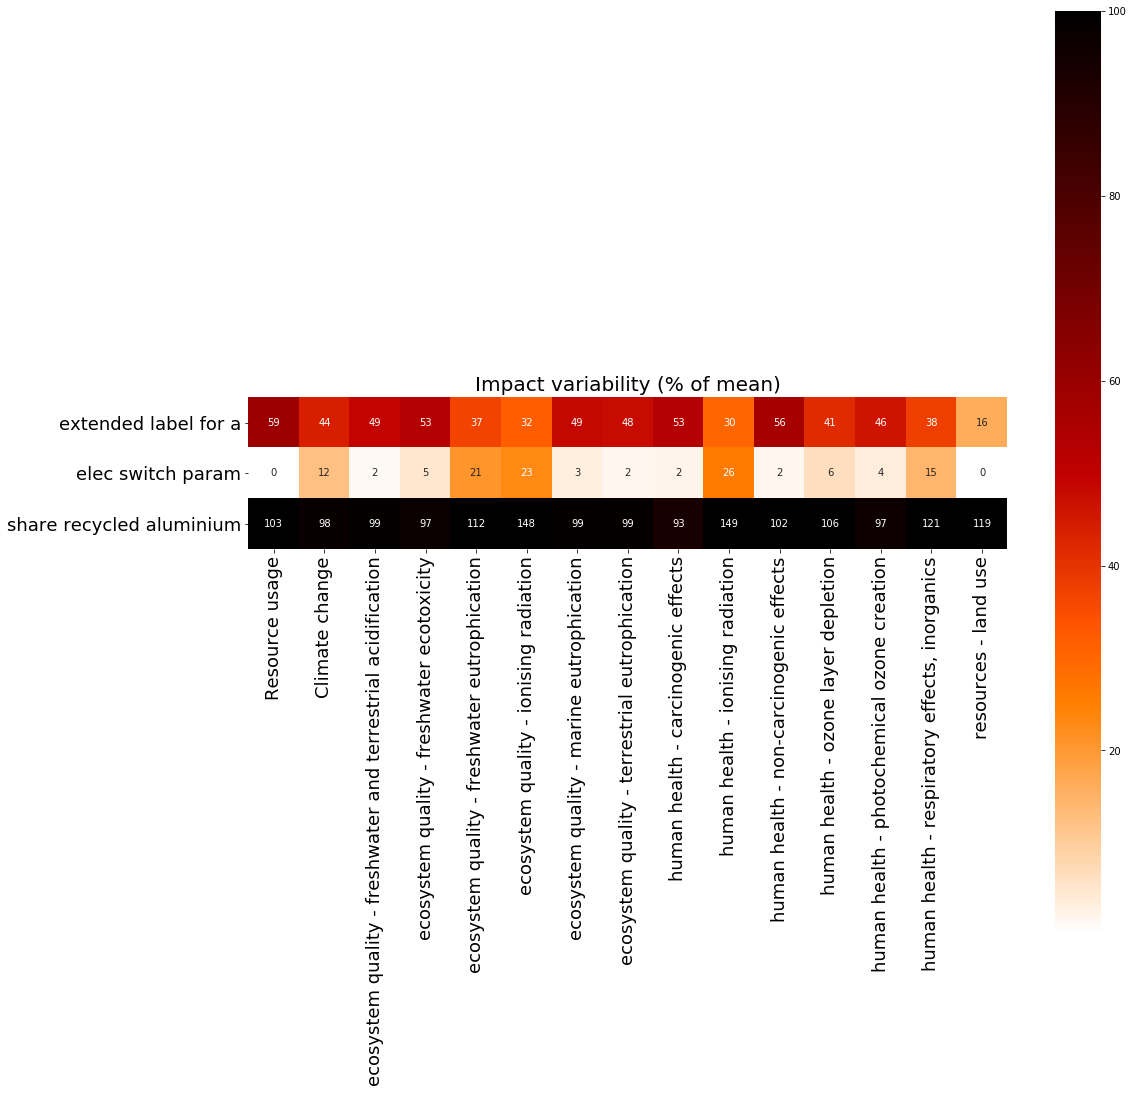

In [30]:
oat_matrix(model, impacts)

### oat_dashboard_matrix

This functions draws a dashboard showing :
* A dropdown list, for choosing a parameter
* Several graphs of evolution of impacts for this parameter
* Full table of data
* A graph of "bars" representing the variation of each impact for this parameter (similar to the information given in oat_matrix) 

In [31]:
oat_dashboard_interact(
    model, impacts, 
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

interactive(children=(Dropdown(description='param', options=('a', 'elec_switch_param', 'share_recycled_alumini…

## Monte-carlo methods & Sobol indices

Here we leverage fast computation of monte-carlo approches. 

We compute **global sensivity analysis** (GSA).
Not only local ones.


### Sobol Matrix 

Similar to OAT matrix, we compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

for easier comparison, we translate those relative sobol indices into "deviation / mean" importance :

$$RelativeDeviation = \frac{\sqrt{sobol(param) \times totalVariance(impact))}}{mean(impact)}$$




In [32]:
# Show sobol indices 
incer_stochastic_matrix(model, impacts)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'mineral, fossils and renewables')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'climate change', 'GWP 100a')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater and terrestrial acidification')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater ecotoxicity')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'ionising radiation')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'marine eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'terrestrial eutrophication')
Process

interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…

###  Graphs of impacts and their distribution

We provide a dashboard showing **violin graphs** : the exact probabilistic distribution for each impact. Together with medians of the impacts.

Generating samples ...
Transforming samples ...


Param 'b' is marked as FIXED, but passed in parameters : ignored


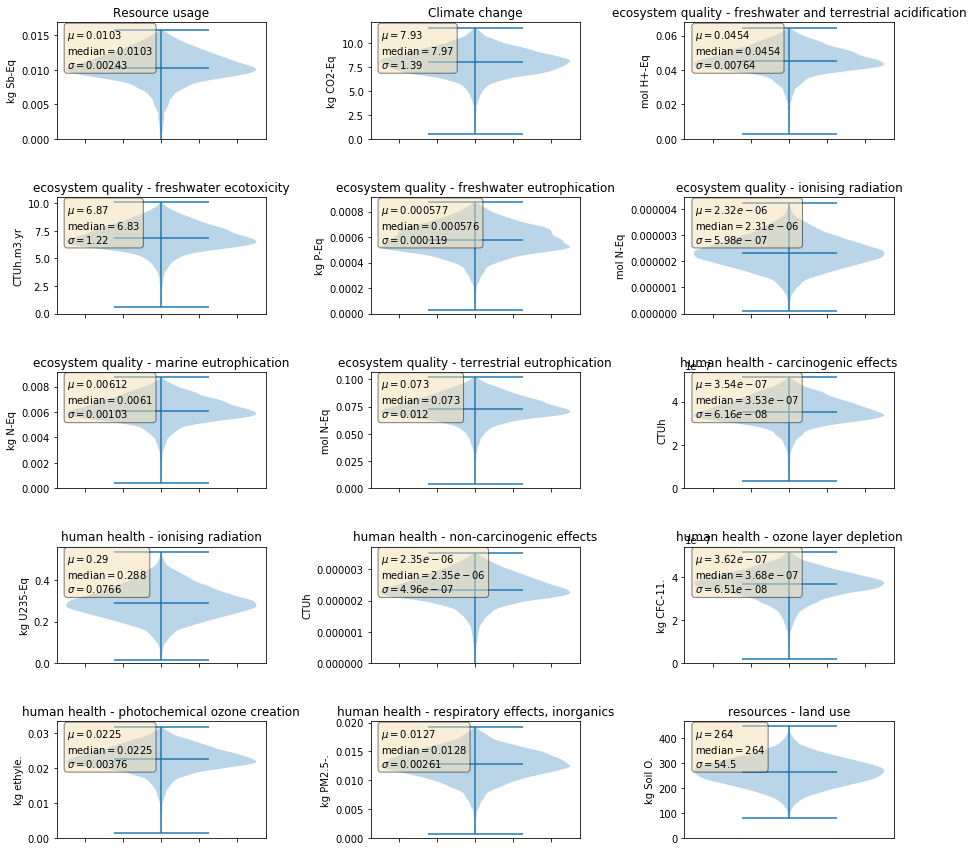

In [33]:
incer_stochastic_violin(
    model, impacts,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Generating samples ...
Transforming samples ...


Param 'b' is marked as FIXED, but passed in parameters : ignored


,Resource usage [kg Sb-Eq / kWh],Climate change [kg CO2-Eq / kWh],ecosystem quality - freshwater and terrestrial acidification [mol H+-Eq / kWh],ecosystem quality - freshwater ecotoxicity [CTUh.m3.yr / kWh],ecosystem quality - freshwater eutrophication [kg P-Eq / kWh],ecosystem quality - ionising radiation [mol N-Eq / kWh],ecosystem quality - marine eutrophication [kg N-Eq / kWh],ecosystem quality - terrestrial eutrophication [mol N-Eq / kWh],human health - carcinogenic effects [CTUh / kWh],human health - ionising radiation [kg U235-Eq / kWh],human health - non-carcinogenic effects [CTUh / kWh],human health - ozone layer depletion [kg CFC-11. / kWh],human health - photochemical ozone creation [kg ethyle. / kWh],"human health - respiratory effects, inorganics [kg PM2.5-. / kWh]",resources - land use [kg Soil O. / kWh]
median,0.0103354,7.97502,0.0453042,6.83672,0.000575822,2.31096e-06,0.00610773,0.0729293,3.52286e-07,0.287978,2.35041e-06,3.67887e-07,0.0225549,0.0127728,264.043
std,0.00241918,1.38383,0.00761456,1.21397,0.000118535,5.9669e-07,0.00102499,0.0119723,6.14161e-08,0.0765116,4.93822e-07,6.49994e-08,0.00375232,0.00260405,54.4061
p,"[0.006023220169773611, 0.0138676524576231]","[5.629625120064793, 10.091416619812927]","[0.03278971629930504, 0.057536041121099266]","[4.9111532591289295, 8.848234983057926]","[0.00038110769804725097, 0.0007659789826786883]","[1.343937531983165e-06, 3.322835916043601e-06]","[0.00443152724422405, 0.007749661422027176]","[0.05291725216881531, 0.09171051623461154]","[2.528757633977035e-07, 4.5361414282291875e-07]","[0.1667815682181064, 0.42092813970485343]","[1.5042667477112382e-06, 3.1040619445319275e-06]","[2.4586453589047684e-07, 4.579091863390413e-07]","[0.016084375823452412, 0.028314497585451168]","[0.008140025818130758, 0.016646070910413868]","[173.45101252530444, 352.3945801937672]"
mean,0.0102566,7.92583,0.0454203,6.87331,0.000577044,2.31996e-06,0.00612111,0.0729498,3.53972e-07,0.290299,2.34524e-06,3.62399e-07,0.0225034,0.0126608,263.585
var,0.235865,0.174597,0.167647,0.176622,0.205418,0.257198,0.167452,0.164117,0.173505,0.263561,0.210564,0.179359,0.166744,0.205678,0.206408


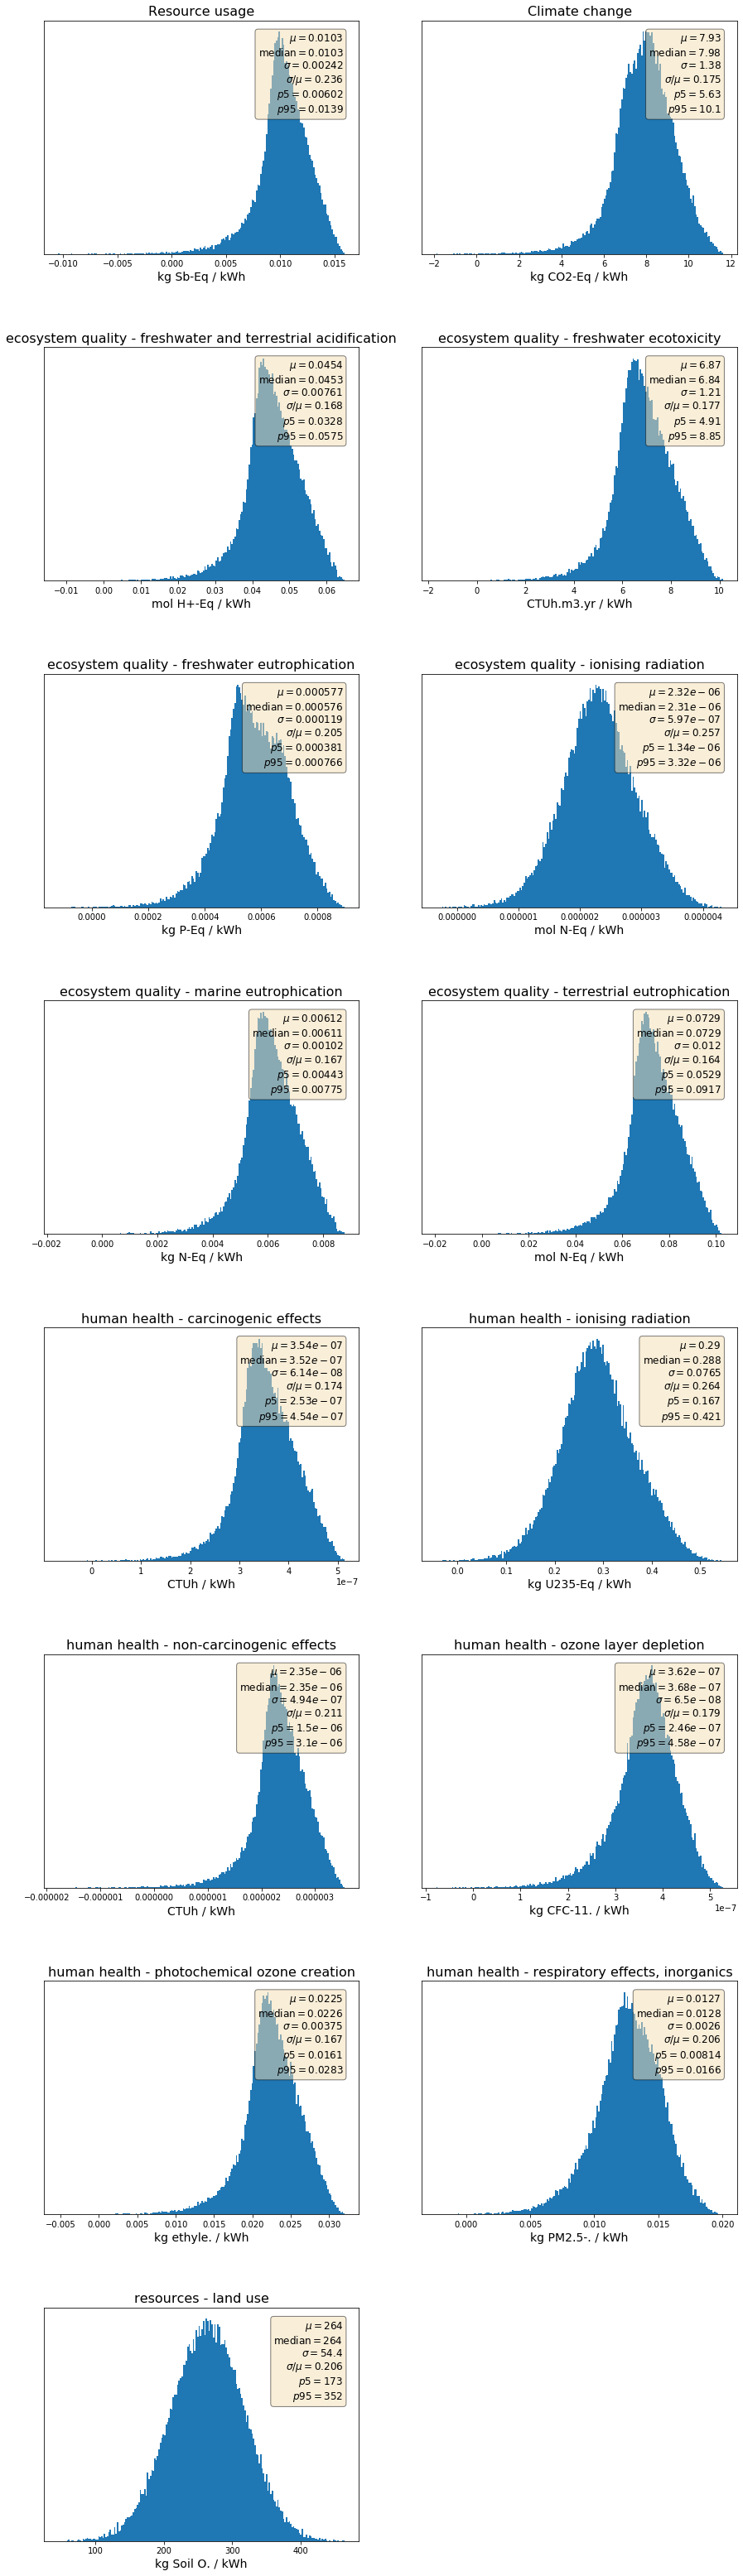

In [34]:
##### Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes
distrib(
    model, impacts,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

### Full dashboard

A dashboard groups all this information in a single interface with tabs.

It also shows total variation of impacts. This last graph could be improved by showing stacked colored bars with the contribution of each parameter to this variation, according to Sobol indices. 

In [45]:
incer_stochastic_dashboard(model=model, methods=impacts)

Generating samples ...
Transforming samples ...


Param 'b' is marked as FIXED, but passed in parameters : ignored


Processing Sobol indices ...
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'mineral, fossils and renewables')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'climate change', 'GWP 100a')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater and terrestrial acidification')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater ecotoxicity')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'ionising radiation')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'marine eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'terrestrial eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (

# Producing simplified models 

One of te outcome of the statisticall analysis above would be to identify main input parameters and produce simplidied models, fixing the minor ones.

We provide several functions for doing this.

## Explore initial algrebraic model

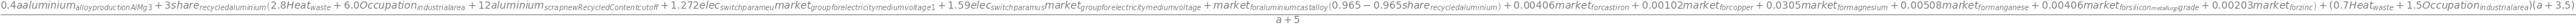

In [36]:
# First, let's look at the full expression defining our model
expr, _ = actToExpression(normalized_model)
expr

## Compute simplified models

We provide some method to automatically select a subset of parameters, based on the **sobol indices**, and then compute simplified models for it.

We also round numerical expression to 3 digits, and we remove terms in sums that are less than 1% of total.

Generating samples ...
Transforming samples ...


Param 'b' is marked as FIXED, but passed in parameters : ignored


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'mineral, fossils and renewables')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'climate change', 'GWP 100a')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater and terrestrial acidification')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater ecotoxicity')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'ionising radiation')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'marine eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'terrestrial eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'human health', '

> Method :  Climate change
S1:  0.972312713265432
S2:  0.03108774835824793
ST:  1.0231853970256206
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.8654475873696057


                             ⎛                              ⎛⎧0.545  for ElecS
0.514⋅ShareRecycledAluminium⋅⎜-4.3⋅ShareRecycledAluminium + ⎜⎨                
                             ⎝                              ⎝⎩1.05   for ElecS

witchParam = Eu⎞       ⎞        
               ⎟ + 5.32⎟ + 0.329
witchParam = Us⎠       ⎠        

> Method :  ecosystem quality - freshwater and terrestrial acidification
S1:  0.9985199973685366
S2:  -0.003961684013821801
ST:  1.0060124601361182
Selected params :  ['share_recycled_aluminium'] explains:  0.804302260197975


> Method :  ecosystem quality - freshwater ecotoxicity
S1:  0.9934658493878188
S2:  -0.003591312844785751
ST:  1.0077483400120841
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9637730841759999


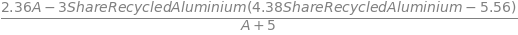

> Method :  ecosystem quality - freshwater eutrophication
S1:  0.9590186966001336
S2:  0.04381108902431924
ST:  1.0358599962347754
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9352353901303712


                             ⎛                                   ⎛⎧ 6.2e-5   f
0.512⋅ShareRecycledAluminium⋅⎜-0.000231⋅ShareRecycledAluminium + ⎜⎨           
                             ⎝                                   ⎝⎩0.000125  f

or ElecSwitchParam = Eu⎞          ⎞          
                       ⎟ + 0.00031⎟ + 2.06e-5
or ElecSwitchParam = Us⎠          ⎠          

> Method :  ecosystem quality - ionising radiation
S1:  0.9719501235495673
S2:  0.023411172155669863
ST:  1.0258079512120246
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.96834915124387


                             ⎛                                  ⎛⎧9.56e-7  for
0.513⋅ShareRecycledAluminium⋅⎜-4.24e-7⋅ShareRecycledAluminium + ⎜⎨            
                             ⎝                                  ⎝⎩6.74e-7  for

 ElecSwitchParam = Us⎞          ⎞          
                     ⎟ + 5.15e-7⎟ + 7.01e-8
 ElecSwitchParam = Eu⎠          ⎠          

> Method :  ecosystem quality - marine eutrophication
S1:  0.9956186127058981
S2:  0.0017684898355731851
ST:  1.0070984838473842
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9817718380594843


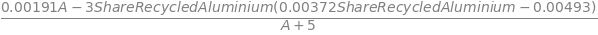

> Method :  ecosystem quality - terrestrial eutrophication
S1:  1.0000010128657375
S2:  0.0041065374598224765
ST:  1.0074461051530517
Selected params :  ['share_recycled_aluminium'] explains:  0.8392626918396056


> Method :  human health - carcinogenic effects
S1:  0.9967180536517019
S2:  0.012943640305802447
ST:  1.0063246049256778
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9913972081360208


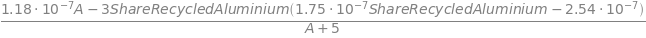

> Method :  human health - ionising radiation
S1:  0.968002703037859
S2:  0.026917695254938406
ST:  1.0295738242024866
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9660071530774667


                             ⎛                                 ⎛⎧0.0833  for E
0.511⋅ShareRecycledAluminium⋅⎜-0.0543⋅ShareRecycledAluminium + ⎜⎨             
                             ⎝                                 ⎝⎩0.123   for E

lecSwitchParam = Eu⎞         ⎞          
                   ⎟ + 0.0657⎟ + 0.00857
lecSwitchParam = Us⎠         ⎠          

> Method :  human health - non-carcinogenic effects
S1:  0.9999407005892093
S2:  -0.03649544794672706
ST:  1.0031652451011994
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9980749432725429


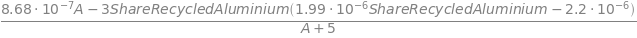

> Method :  human health - ozone layer depletion
S1:  0.9895955907975253
S2:  0.020451133809570317
ST:  1.0098869449519126
Selected params :  ['share_recycled_aluminium'] explains:  0.8975456733085345


> Method :  human health - photochemical ozone creation
S1:  0.9937754436413623
S2:  0.015487693629801097
ST:  1.0079847835078861
Selected params :  ['share_recycled_aluminium'] explains:  0.8431908857999599


> Method :  human health - respiratory effects, inorganics
S1:  0.9771801054048728
S2:  0.026122079648410276
ST:  1.0200539975877807
Selected params :  ['share_recycled_aluminium'] explains:  0.8132248808317574


> Method :  resources - land use
S1:  0.9962502104818469
S2:  -0.006349560607685791
ST:  1.0036815580050527
Selected params :  ['share_recycled_aluminium'] explains:  0.9740608386076699


In [37]:
simplified = sobol_simplify_model(
    normalized_model, # The model
    impacts, # Impacts to consider
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain

    num_digits=3)

In [40]:
# Let's look at the expression for first impact again 
# much simpler ! 
simplified[0].expr

## Compare simplified model with full model

Finally, we can compare the distribution of those simplified model against the full model. We provide a function for graphical display of it, and compuation of de R-Square score.


Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...


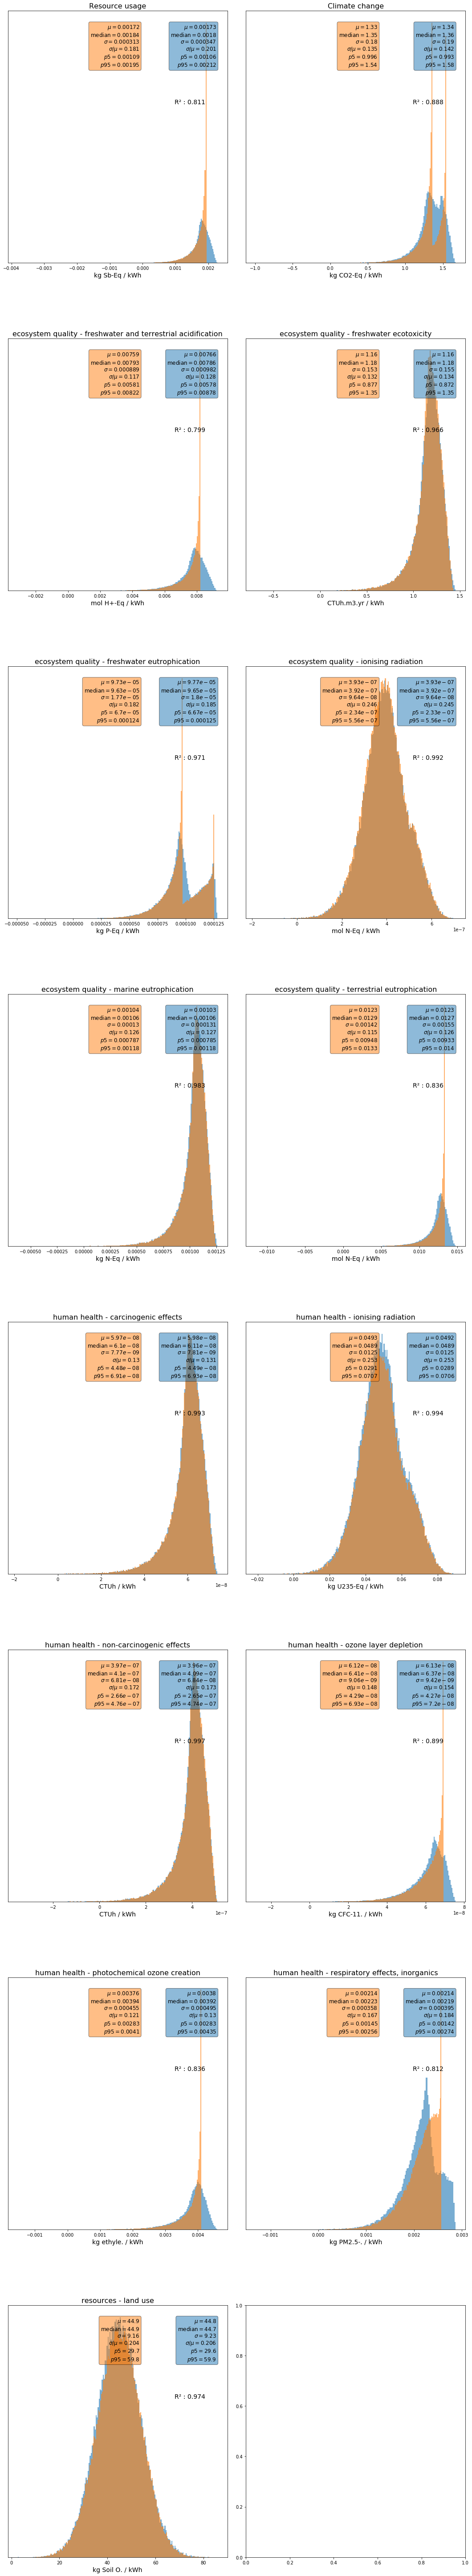

In [39]:
compare_simplified(normalized_model, impacts, simplified)